In [ ]:
#useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import ks_2samp
from sklearn.metrics import mean_absolute_error
import seaborn as sns

We previously try to simulate FX prices EUR/USD. We ended up choosing Merton Jumps. so we now have a dataframe with simulated FX prices for a one year period. Parameters can be adjusted, we can work either with a short interval and a big interval (depending how you get the data, yf, API, BL). But now we want to add an other variable for our clustering, the traded volume, for that we are going to simulate the traded volumes. The main concern in this part is that its difficukt to have access to shor term traded volume. It was impossible to get them by fetching on yf.

Here our approach tends to use historical volume data from 2003 to 2021. We have the volume of EUR/USD traded by 4h packets. We try to find a method that fits the best thoose historical data, we assumed that if from a global point of view it works, thats great. If we divide the results by the number of five minutes packet, it should be a good approxiamtion. We could aslo find some scaling techniques to pass from an time scale to another by annualizing techniques. Since we are working with volumes, we don't apply any transformation to the (no log, or filter).

We are going to base our approach on two point of view:
- mathematical simulation (compare volumes with simulated distribution using estimated parameters from historical data)
- machine learning (use other variables to predict volumes, based on historical data)

In [ ]:
# Charger les données
data = pd.read_csv("EURUSD_ForexTrading_4hrs_05.05.2003_to_16.10.2021.csv")

# Convertir la colonne 'Gmt time' en datetime
data['Gmt time'] = pd.to_datetime(data['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f', dayfirst=True)
data.index = data['Gmt time']

# Renommer la colonne volume pour plus de clarté
data.rename(columns={'volume': '4H Volume'}, inplace=True)

# Analyse statistique de la distribution des volumes 4H
mu, sigma = norm.fit(data['4H Volume'])

print(f"Moyenne du volume 4H: {mu}, Écart-type: {sigma}")

# Overview of the data

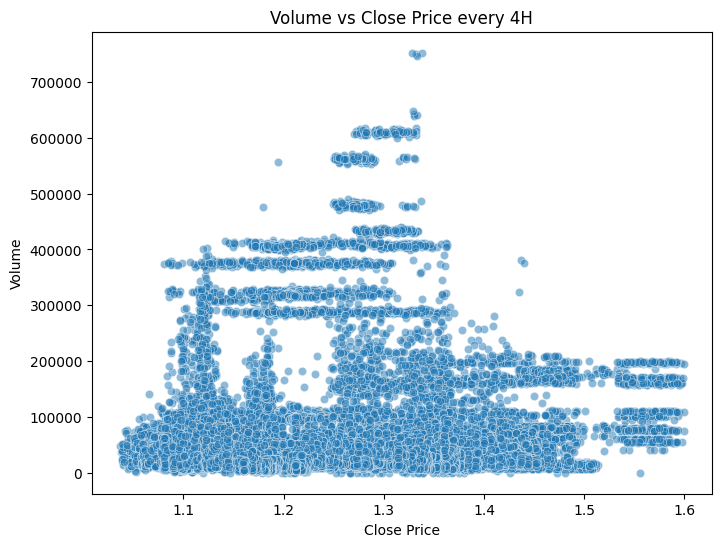

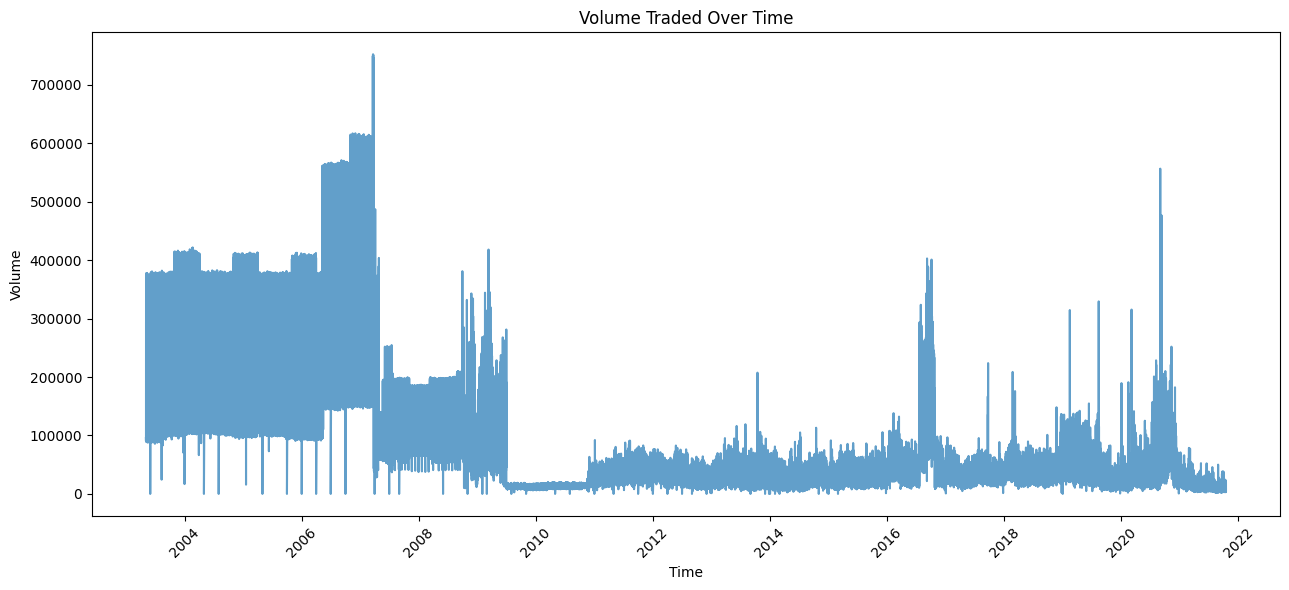

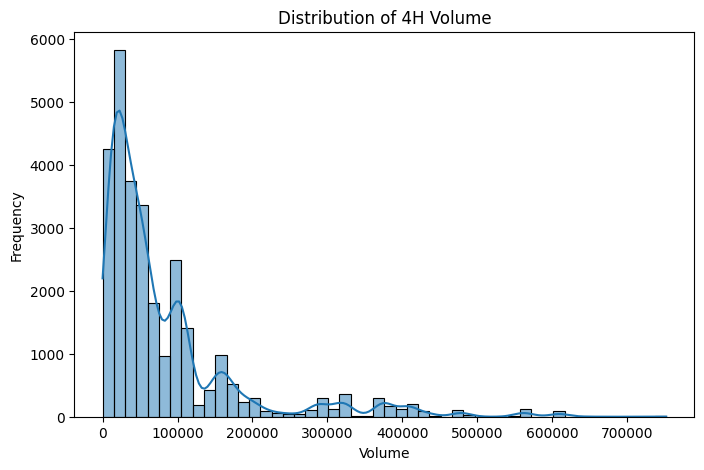

In [57]:
data['Date'] = data.index.date

#we create a daily volum colum  even though we are going to conduct our simulation on 4H data (closer of the real time interval)
daily_volume = data.groupby('Date')['4H Volume'].sum()
# Plot 1: Volume vs. Close price
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['close'], y=data['4H Volume'], alpha=0.5)
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.title('Volume vs Close Price every 4H')
plt.show()

# Plot 2: Volume traded over time (using line plot)
plt.figure(figsize=(13, 6))
sns.lineplot(x=data.index, y=data['4H Volume'], alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('Volume Traded Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Distribution of Volume
plt.figure(figsize=(8, 5))
sns.histplot(data['4H Volume'], bins=50, kde=True)
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('Distribution of 4H Volume')
plt.show()

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EURUSD=X']: possibly delisted; no price data found  (5m 2024-12-14 -> 2024-12-24) (Yahoo error = "5m data not available for startTime=1734134400 and endTime=1734998400. The requested range must be within the last 60 days.")
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetched 9817 data points
Price                         Close      High       Low      Open   Volume
Ticker                     EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X
Datetime                                                                  
2024-12-24 00:00:00+00:00  1.040583  1.040799  1.040583  1.040691        0
2024-12-24 00:05:00+00:00  1.040475  1.040583  1.040475  1.040583        0
2024-12-24 00:10:00+00:00  1.040475  1.040583  1.040475  1.040583        0
2024-12-24 00:15:00+00:00  1.040366  1.040475  1.040366  1.040475        0
2024-12-24 00:20:00+00:00  1.040475  1.040475  1.040366  1.040366        0


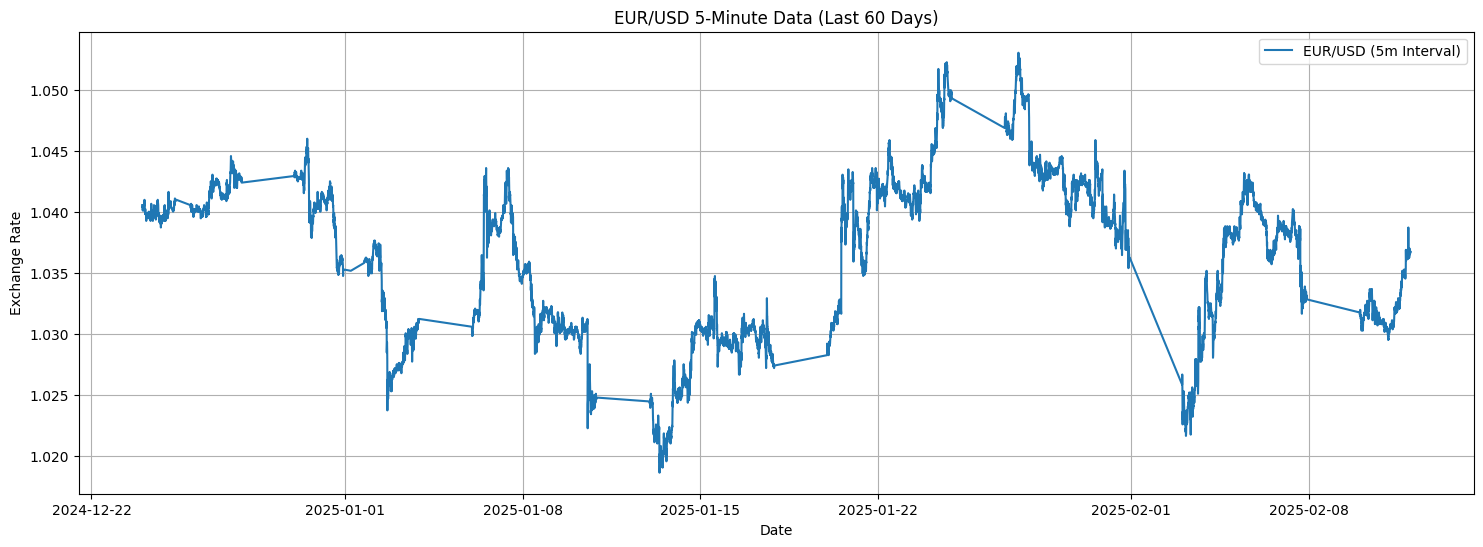

In [58]:
import yfinance as yf
import datetime as dt

# Define parameters
ticker = "EURUSD=X"
end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=60)  # Max allowed for 5-min data
interval = "5m"

# Fetch data in chunks (10-day increments to avoid API limits)
all_data = []
chunk_size = 10
current_start = start_date

while current_start < end_date:
    current_end = min(current_start + dt.timedelta(days=chunk_size), end_date)
    data = yf.download(ticker, start=current_start, end=current_end, interval=interval)

    if not data.empty:
        all_data.append(data)

    current_start = current_end

# Combine chunks into a single DataFrame
fx_data_5m = pd.concat(all_data).dropna()

# Print summary
print(f"Fetched {len(fx_data_5m)} data points")
print(fx_data_5m.head())

# Plot data
plt.figure(figsize=(18, 6))
plt.plot(fx_data_5m.index, fx_data_5m["Close"], label="EUR/USD (5m Interval)")
plt.title("EUR/USD 5-Minute Data (Last 60 Days)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

Data Preprocessing and features engineering

In [69]:
import pandas as pd
import numpy as np

price_data=fx_data_5m #containing yf price data (5min)
volume_data=data #containing historical data with volumes (4H)

# Price Features (Moving Averages, RSI, Bollinger Bands)
price_data['5min_change'] = price_data['Close'].pct_change()  # Percentage change in 5-min close price
price_data['volatility'] = price_data['Close'].rolling(window=5).std()  # Rolling volatility (standard deviation)
price_data['high_low_range'] = price_data['High'] - price_data['Low']  # High-Low range

# Moving averages (using pandas' rolling method)
price_data['SMA_5'] = price_data['Close'].rolling(window=5).mean()
price_data['SMA_20'] = price_data['Close'].rolling(window=20).mean()

def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# RSI (Relative Strength Index) for momentum
price_data['RSI_14'] = calculate_rsi(price_data['Close'], period=14)

# Bollinger Bands (using pandas' rolling method)
# Calculate the rolling mean and standard deviation separately
rolling_mean = price_data['Close'].rolling(window=20).mean()
rolling_std = price_data['Close'].rolling(window=20).std()

# Then calculate the upper and lower bands using the rolling mean and std
price_data['upper_band'] = rolling_mean + 2 * rolling_std
price_data['lower_band'] = rolling_mean - 2 * rolling_std

price_data.head()

Price,Close,High,Low,Open,Volume,5min_change,volatility,high_low_range,SMA_5,SMA_20,RSI_14,middle_band,upper_band,lower_band
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,,,,,,,,,
Datetime,,,,,,,,,,,,,,


resampling of the historical data, and creation of enginered features

In [68]:
#Volume Features (from 4-hour data)
# Resample volume_data to 5-minute intervals by distributing the 4-hour volume across the 5-minute intervals
# For simplicity, we'll assume equal distribution of the 4-hour volume across 48 intervals (5 minutes each)
volume_data['datetime'] = pd.to_datetime(volume_data['datetime'])
volume_data.set_index('datetime', inplace=True)

# Resample volume data from 4-hour to 5-minute intervals by forward filling volume (or another method you prefer)
volume_resampled = volume_data.resample('5T').ffill()  # '5T' means 5-minute intervals

# Create a new column with the volume distributed evenly across 5-minute periods within the 4-hour window
volume_resampled['volume_5min'] = volume_resampled['volume'] / 48  # Distribute volume across 48 intervals

# Now, merge the resampled volume data with the 5-minute price data
#Tbh i'm not sure about the merging part, really weird but it was easier
merged_data = pd.merge(price_data, volume_resampled[['volume_5min']], left_index=True, right_index=True, how='left')

# Calculate the relative volume (volume at 5-min interval relative to the total 4-hour volume)
merged_data['relative_volume'] = merged_data['volume_5min'] / merged_data['volume_5min'].rolling(window=48).sum()

features = merged_data[['5min_change', 'volatility', 'high_low_range', 'SMA_5', 'SMA_20', 'RSI_14',
                        'upper_band', 'middle_band', 'lower_band', 'relative_volume']]
features.head()

KeyError: 'datetime'

so finally we have the data set price_data containing data from yf and all computed additionnal features, and we have features, containing the historical data, reseampled and with additional features

# **Statistical approach**

in our mathematical approach, we try to find a ditribution taht could fit the one of volumes. We implement the most basics ones as an overview to then go to more adavnace statistical modelling (maybe with a kernel?)

**Poisson process**

hre we estimate lambda using our historical data

In [ ]:
# Calculate basic statistics
mu = data['4H Volume'].mean()
sigma = data['4H Volume'].std()
lambda_poisson = mu # Poisson parameter is the mean of the data

# Simulation functions
def simulate_poisson(n_periods, lambda_param):
    """Simulate volumes using Poisson process"""
    return np.random.poisson(lambda_param, size=n_periods)


**ARIMA**

Great models when there's a strong time-series autocorrelation in transaction volumes (i.e., current volumes depend on past volumes).
ARIMA might not capture complex market behavior (such as abrupt jumps or changes in trend).

In [43]:
from statsmodels.tsa.arima.model import ARIMA
def simulate_arima(data, n_periods):
    model = ARIMA(data, order=(5, 1, 0))  # Example ARIMA(5,1,0) model, adjust as needed
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=n_periods)
    return forecast

**Gaussian mixture model**

In [44]:
def simulate_gaussian_mixture(n_periods, mu, sigma):
    """Simulate volumes using Gaussian Mixture for different trading sessions"""
    asian_vol = np.random.normal(mu*0.6, sigma*0.5, n_periods//3)
    european_vol = np.random.normal(mu*1.2, sigma*0.8, n_periods//3)
    american_vol = np.random.normal(mu*1.1, sigma*0.7, n_periods//3)
    return np.concatenate([asian_vol, european_vol, american_vol])


**log normal**

In [45]:
def simulate_lognormal(n_periods, mu, sigma):
    """Simulate volumes using Log-normal distribution"""
    log_mu = np.log(mu/np.sqrt(1 + (sigma/mu)**2))
    log_sigma = np.sqrt(np.log(1 + (sigma/mu)**2))
    return np.random.lognormal(log_mu, log_sigma, size=n_periods)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


Simulation Metrics:
                           Mean           Std  KS Statistic            MAE
Poisson           413774.710000    606.595125      1.000000  395618.926691
Log-normal            16.450625     21.791586      0.990000   18139.454186
ARIMA              53355.858214  12079.972311      0.970000   35200.074905
Gaussian Mixture      11.976871      9.364932      0.989899   18093.109342


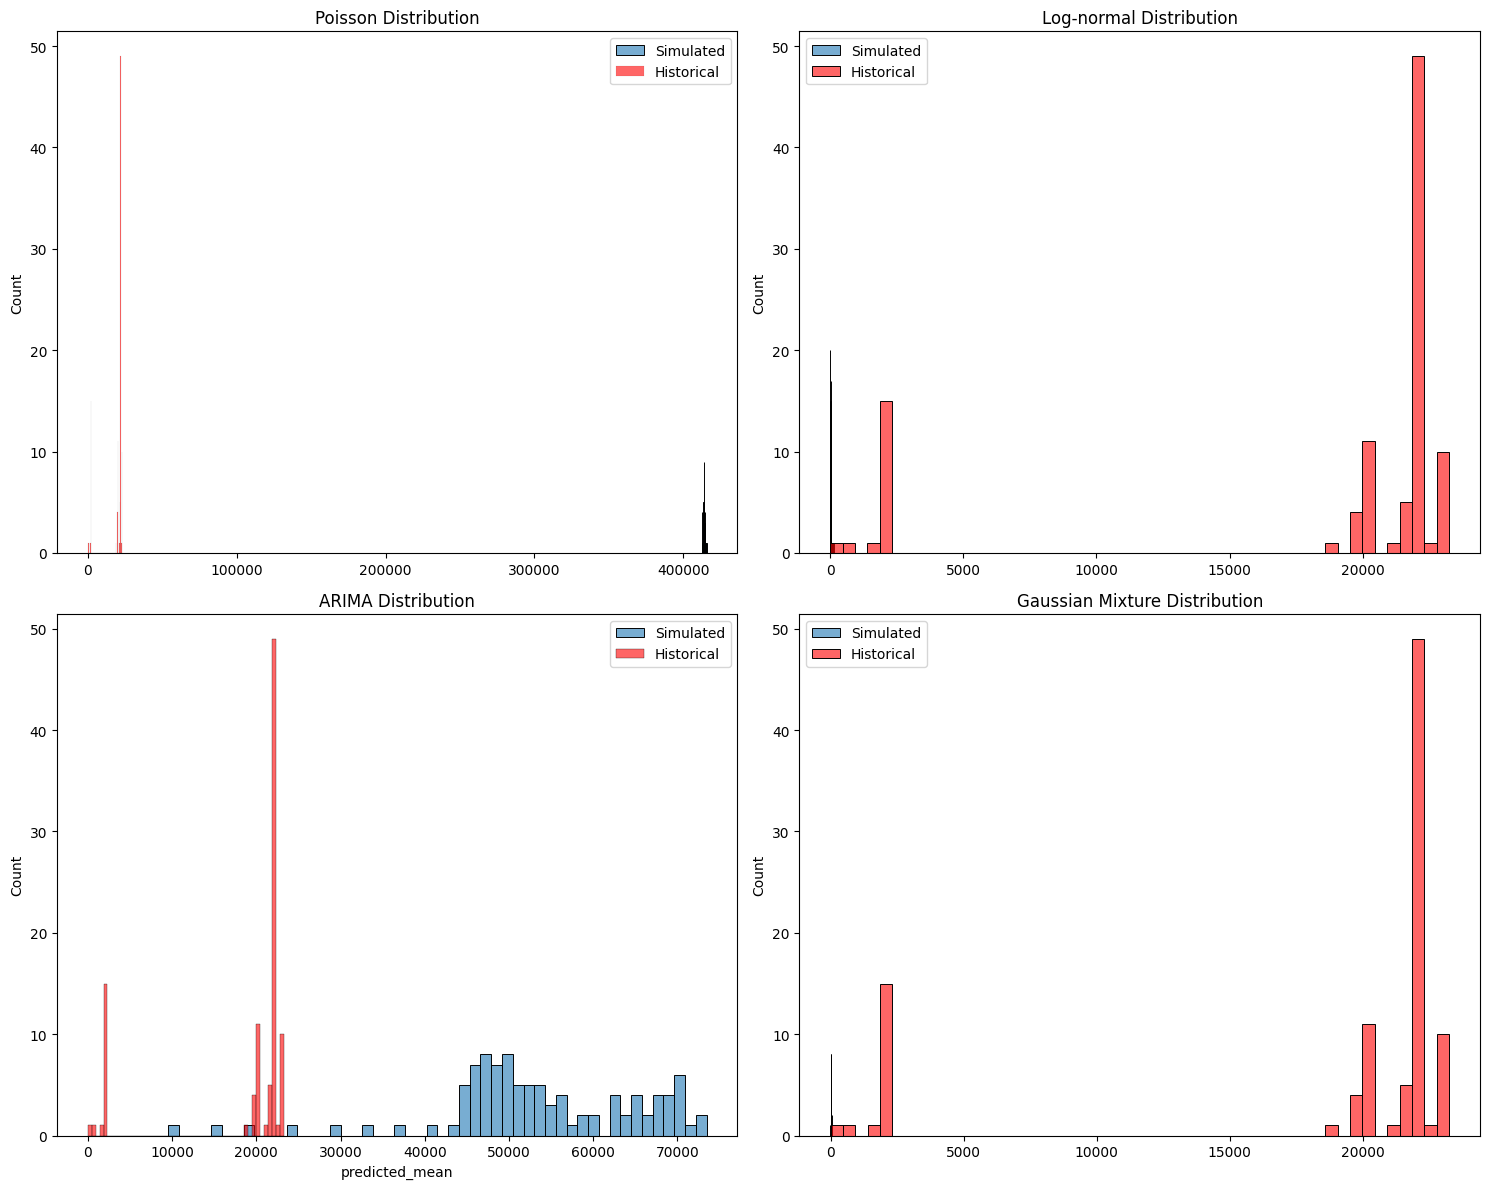

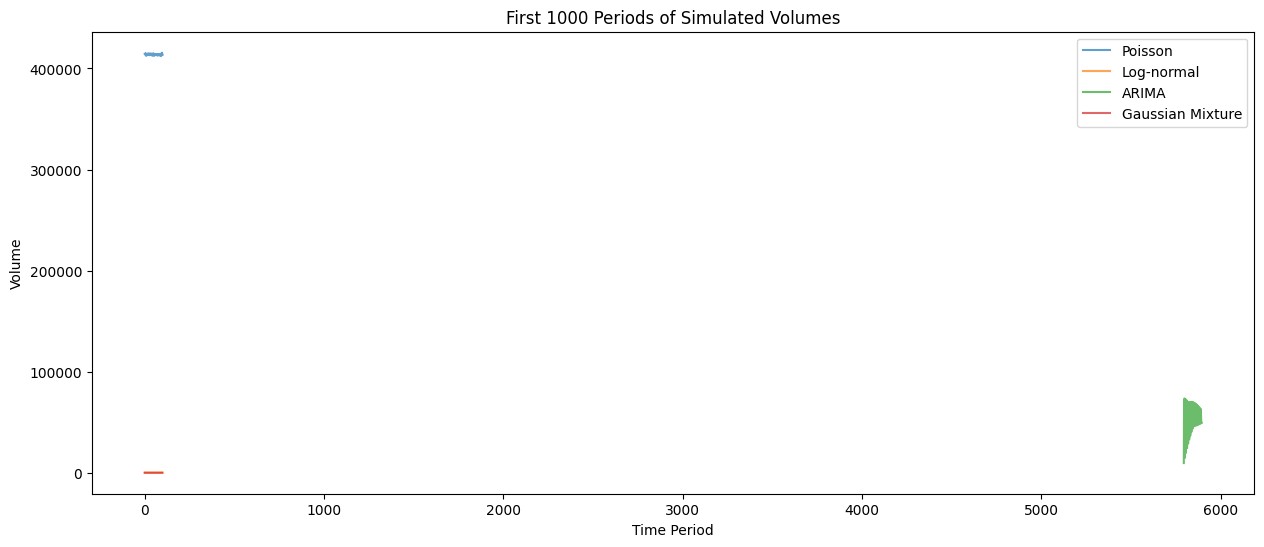

In [46]:
daily_volume = daily_volume.astype(np.float64)

# Example parameters
n_periods = 100
mu = np.log(daily_volume.mean())  # Log-transformed mean for Log-normal
sigma = np.log(daily_volume.std())  # Log-transformed std for Log-normal
lambda_poisson = daily_volume.mean()  # Mean for Poisson lambda



# Simulate data using different methods
simulations = {
    'Poisson': simulate_poisson(n_periods, lambda_poisson),
    'Log-normal': simulate_lognormal(n_periods, mu, sigma),
    'ARIMA': simulate_arima(daily_volume, n_periods),
    'Gaussian Mixture': simulate_gaussian_mixture(n_periods, mu, sigma)
}

# Calculate metrics
metrics = {}
historical_5min = daily_volume.values[:n_periods] / 48  # Convert to 5min

for method_name, simulated_data in simulations.items():
    min_length = min(len(historical_5min), len(simulated_data))
    metrics[method_name] = {
        'Mean': np.mean(simulated_data),
        'Std': np.std(simulated_data),
        'KS Statistic': ks_2samp(historical_5min[:min_length], simulated_data[:min_length])[0],
        'MAE': mean_absolute_error(historical_5min[:min_length], simulated_data[:min_length])
    }

metrics_df = pd.DataFrame(metrics).T
print("\nSimulation Metrics:")
print(metrics_df)

# Create visualizations
plt.figure(figsize=(15, 12))
for idx, (method_name, simulated_data) in enumerate(simulations.items(), 1):
    plt.subplot(2, 2, idx)
    sns.histplot(data=simulated_data, bins=50, alpha=0.6, label='Simulated')
    sns.histplot(data=historical_5min, bins=50, alpha=0.6, label='Historical', color='red')
    plt.title(f'{method_name} Distribution')
    plt.legend()
plt.tight_layout()
plt.show()

# Time series plot
plt.figure(figsize=(15, 6))
for method_name, simulated_data in simulations.items():
    plt.plot(simulated_data[:1000], label=method_name, alpha=0.7)
plt.title('First 1000 Periods of Simulated Volumes')
plt.xlabel('Time Period')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [47]:
# Correlation analysis
correlations = {}
for method_name, simulated_data in simulations.items():
    min_length = min(len(historical_5min), len(simulated_data))
    correlations[method_name] = np.corrcoef(historical_5min[:min_length], simulated_data[:min_length])[0, 1]

correlations_df = pd.DataFrame(correlations, index=['Correlation']).T
print("\nCorrelation Analysis:")
print(correlations_df)


Correlation Analysis:
                  Correlation
Poisson             -0.084239
Log-normal           0.106808
ARIMA                0.547969
Gaussian Mixture     0.067128


we can clearly see that using parametric distribution was a fail (all of them). We try to implement other model. we are going also to use parameters estimated using the historical price data, and to change to the righ time interval for volume simmulation. But this historicall approach is maybe not the best since we want to work in 5 min time interval.
ARIMA seems to be the most promising model among the shit.
Poisson is the least useful model for this dataset.
Other models (Log-normal and Gaussian Mixture) do not explain much of the variability in the volume data.

We try to implement more sofisticated methods

**Hawkes Process**

implemented in three parts :

Step 1 (Fit) → Learn Hawkes parameters from real data.

Step 2 (Simulate) → Generate synthetic transactions based on the fitted model.

Step 3 (Aggregate & Compare) → Group synthetic transactions into 4-hour bins and check if they match real data.

for Event-Driven and Clustering Behavior. Best for Modeling transaction clustering or self-exciting behavior.
fix tick



Fit

In [48]:
"""!pip install tick
from tick.hawkes import HawkesExpKern
import numpy as np

volume_data = data['4H Volume']  # Use the correct volume column

# 🔹 Convert 4H volume data to event timestamps
event_timestamps = []
for i, (timestamp, volume) in enumerate(volume_data.items()):
    # Generate 'volume' number of events uniformly in this 4H window
    # Ensure 'volume' is an integer
    volume = int(volume)
    event_times = np.random.uniform(0, 4 * 3600, volume)  # Convert 4H to seconds
    event_timestamps.extend(timestamp.timestamp() + event_times)  # Convert datetime to Unix time

# Sort timestamps
event_timestamps = np.sort(event_timestamps)

# Convert to list of lists (required format for tick)
hawkes_events = [event_timestamps.tolist()]

# 🔹 Fit the Hawkes process model
hawkes = HawkesExpKern(decay=0.1)  # Initial decay rate
hawkes.fit(hawkes_events)

# 🔹 Print estimated parameters
print(f"Estimated baseline intensity: {hawkes.baseline}")
print(f"Estimated excitation (alpha): {hawkes.adjacency}")

# 🔹 Visualize intensity over time
import matplotlib.pyplot as plt

hawkes.plot_intensity(hawkes_events, end_time=86400)  # Plot over one day
plt.show()"""

'!pip install tick\nfrom tick.hawkes import HawkesExpKern\nimport numpy as np\n\nvolume_data = data[\'4H Volume\']  # Use the correct volume column\n\n# 🔹 Convert 4H volume data to event timestamps\nevent_timestamps = []\nfor i, (timestamp, volume) in enumerate(volume_data.items()):\n    # Generate \'volume\' number of events uniformly in this 4H window\n    # Ensure \'volume\' is an integer\n    volume = int(volume)\n    event_times = np.random.uniform(0, 4 * 3600, volume)  # Convert 4H to seconds\n    event_timestamps.extend(timestamp.timestamp() + event_times)  # Convert datetime to Unix time\n\n# Sort timestamps\nevent_timestamps = np.sort(event_timestamps)\n\n# Convert to list of lists (required format for tick)\nhawkes_events = [event_timestamps.tolist()]\n\n# 🔹 Fit the Hawkes process model\nhawkes = HawkesExpKern(decay=0.1)  # Initial decay rate\nhawkes.fit(hawkes_events)\n\n# 🔹 Print estimated parameters\nprint(f"Estimated baseline intensity: {hawkes.baseline}")\nprint(f"Estima

# ML Approach

Machine Learning approach for volume simulation. Since we are working with a dataset containing a lot of variables, we can try to implement linear regression and othe rapproach to predict volumes using prices. Here we test some classical ML approaches like random forest.

But in fact these approaches can only be use if our model of regime detection have access to traded volumes on correct time intervals (Bl in fine). So here we just check if Ml can work well predicting the traded volumes

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Feature Engineering
features = data[['open', 'high', 'low', 'close']]
target = data['4H Volume']

# Create lag features for past 4 periods (16H history)
for lag in range(1, 5):
    features[f'lag_{lag}'] = target.shift(lag)

# Drop NaN values
features.dropna(inplace=True)
target = target.loc[features.index]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

<ipython-input-49-eb77f020e2ef>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[f'lag_{lag}'] = target.shift(lag)
<ipython-input-49-eb77f020e2ef>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[f'lag_{lag}'] = target.shift(lag)
<ipython-input-49-eb77f020e2ef>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [50]:
#Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print(f'Linear Regression MAE: {mean_absolute_error(y_test, y_pred_lr)}')

Linear Regression MAE: 36989.61104831936


In [51]:
# Model 2: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f'Random Forest MAE: {mean_absolute_error(y_test, y_pred_rf)}')

Random Forest MAE: 8502.974925930575


In [52]:
#Model 3: LSTM
# Reshape data for LSTM: (samples, time_steps, features)
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

#Define LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(1, X_train.shape[1])),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)

y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
print(f'LSTM MAE: {mean_absolute_error(y_test, y_pred_lstm)}')

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


722/722 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 16943364096.0000
Epoch 2/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17073963008.0000
Epoch 3/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17186117632.0000
Epoch 4/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 16991920128.0000
Epoch 5/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 16807474176.0000
Epoch 6/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 15824074752.0000
Epoch 7/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 14993131520.0000
Epoch 8/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 15300757504.0000
Epoch 9/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 14417025024.0000
Epoch 10/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14347374592.0000
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM MAE: 65068.183058420094


902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


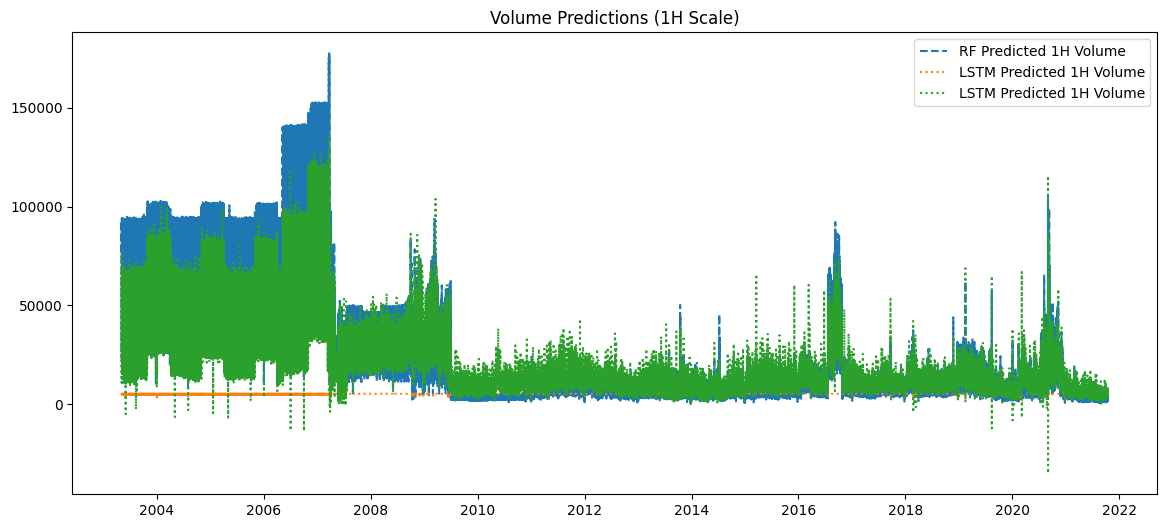

In [54]:
#Predict Full 4H Volume
predicted_4H_lr = pd.Series(lr_model.predict(features), index=features.index)
predicted_4H_rf = pd.Series(rf_model.predict(features), index=features.index)
predicted_4H_lstm = pd.Series(lstm_model.predict(np.reshape(features.values, (features.shape[0], 1, features.shape[1]))).flatten(), index=features.index)

#Scale to 1H and 5min
data.loc[features.index, 'ML 1H Volume (LR)'] = predicted_4H_lr / 4
data.loc[features.index, 'ML 5min Volume (LR)'] = predicted_4H_lr / (4 * 12)

data.loc[features.index, 'ML 1H Volume (RF)'] = predicted_4H_rf / 4
data.loc[features.index, 'ML 5min Volume (RF)'] = predicted_4H_rf / (4 * 12)

data.loc[features.index, 'ML 1H Volume (LSTM)'] = predicted_4H_lstm / 4
data.loc[features.index, 'ML 5min Volume (LSTM)'] = predicted_4H_lstm / (4 * 12)

#review if we should dive or ressample the data or even annualize it to get a better prediction

#Visualization
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['ML 1H Volume (RF)'], label='RF Predicted 1H Volume', linestyle='dashed')
plt.plot(data.index, data['ML 1H Volume (LSTM)'], label='LSTM Predicted 1H Volume', linestyle='dotted')
plt.plot(data.index, data['ML 1H Volume (LR)'], label='LSTM Predicted 1H Volume', linestyle='dotted')
plt.legend()
plt.title('Volume Predictions (1H Scale)')
plt.show()



evaluation mtrics for the classical ML approaches

In [55]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ks_2samp
import numpy as np

# Function to evaluate and print all metrics
def evaluate_model(y_true, y_pred, model_name):
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error
    rmse = np.sqrt(mse)

    # R-squared
    r2 = r2_score(y_true, y_pred)

    # Kolmogorov-Smirnov Test
    ks_stat, ks_pvalue = ks_2samp(y_true, y_pred)

    # Correlation Coefficient
    correlation = np.corrcoef(y_true, y_pred)[0, 1]

    # Print all metrics
    print(f"\n{model_name} Performance Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"KS Statistic: {ks_stat:.4f}, P-value: {ks_pvalue:.4f}")
    print(f"Correlation Coefficient: {correlation:.4f}")

# Evaluate Linear Regression
evaluate_model(y_test, y_pred_lr, "Linear Regression")

# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Evaluate LSTM
evaluate_model(y_test, y_pred_lstm, "LSTM")


Linear Regression Performance Metrics:
MAE: 36989.6110
MSE: 4838825401.3822
RMSE: 69561.6662
R² Score: 0.5042
KS Statistic: 0.2063, P-value: 0.0000
Correlation Coefficient: 0.7101

Random Forest Performance Metrics:
MAE: 8502.9749
MSE: 367278973.1007
RMSE: 19164.5238
R² Score: 0.9624
KS Statistic: 0.0329, P-value: 0.0038
Correlation Coefficient: 0.9810

LSTM Performance Metrics:
MAE: 65068.1831
MSE: 13545678990.5825
RMSE: 116385.9055
R² Score: -0.3879
KS Statistic: 0.7450, P-value: 0.0000
Correlation Coefficient: -0.0249


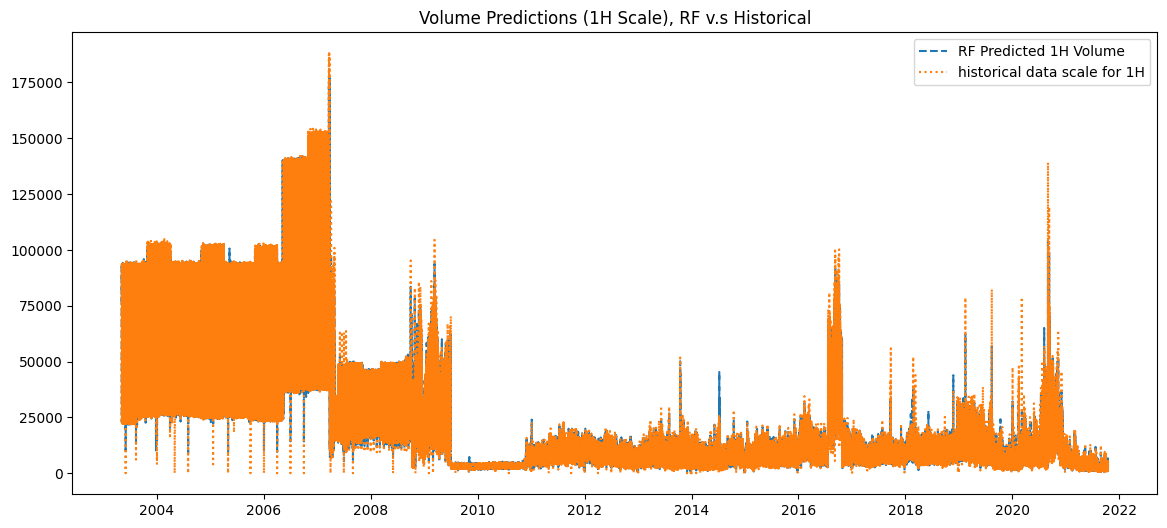

In [56]:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['ML 1H Volume (RF)'], label='RF Predicted 1H Volume', linestyle='dashed')
plt.plot(data.index, data['4H Volume']/4, label='historical data scale for 1H', linestyle='dotted')
plt.legend()
plt.title('Volume Predictions (1H Scale), RF v.s Historical')
plt.show()

we could see here that random forest performed really well compared to the data we have

GANs

for Realistic, Complex Simulations. Best for: Creating very realistic synthetic data that mirrors complex patterns found in transaction volumes.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler

# Extract volume data (make sure column name matches your dataset)
volume_data = data['4H Volume'].values.reshape(-1, 1)  # Ensure it's a 2D array

# Normalize between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
volume_data_scaled = scaler.fit_transform(volume_data)
# Hyperparameters
latent_dim = 100  # Size of the noise vector
gen_hidden_dim = 64
disc_hidden_dim = 64
batch_size = 128
epochs = 500
learning_rate = 0.0002

# Convert dataset to PyTorch tensors
tensor_data = torch.tensor(volume_data_scaled, dtype=torch.float32)
dataset = TensorDataset(tensor_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
generator = Generator(latent_dim, gen_hidden_dim, 1)
discriminator = Discriminator(1, disc_hidden_dim)

# Optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Training Loop
g_losses = []
d_losses = []

for epoch in range(epochs):
    for real_data in dataloader:
        real_data = real_data[0]  # Extract the volume values
        batch_size = real_data.size(0)

        # Create labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator
        d_optimizer.zero_grad()
        real_preds = discriminator(real_data)
        real_loss = criterion(real_preds, real_labels)

        noise = torch.randn(batch_size, latent_dim)
        fake_data = generator(noise).detach()
        fake_preds = discriminator(fake_data)
        fake_loss = criterion(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        fake_data = generator(noise)
        fake_preds = discriminator(fake_data)
        g_loss = criterion(fake_preds, real_labels)  # Want Generator to fool Discriminator
        g_loss.backward()
        g_optimizer.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Training Loss')
plt.show()

In [ ]:
# Generate synthetic data using GAN
noise = torch.randn(100, latent_dim)
generated_volumes = generator(noise).detach().numpy()
generated_volumes = scaler.inverse_transform(generated_volumes)

# Extract the last 100 periods of historical data for comparison
last_historical_volumes = data['4H Volume'].values[-100:]

# Plotting both generated and last historical data for comparison
plt.figure(figsize=(10, 5))
plt.plot(generated_volumes, label='Generated Volume', alpha=0.7)
plt.plot(last_historical_volumes, label='Last Historical Volume', alpha=0.7, color='red')
plt.xlabel('Time Steps')
plt.ylabel('Volume')
plt.legend()
plt.title('Comparison of Generated Volume vs. Last 100 Historical Volumes')
plt.show()

instead of a train test split we should try

In [ ]:
"""from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(data):
    train, test = data.iloc[train_idx], data.iloc[test_idx]"""

and the final test is implementing teh slice, adding volume estimated variable and see if there is an impact on the clustering